In [1]:
import torch

In [2]:
!pip install graphviz

## Graph Plotting function

In [3]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label="{ %s | shape %s | grad %s}" % (n.label, str(n.tensor.shape), str(n.grad.shape)), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Defining a Tensor Value class for auto differentiation

### Broadcasting logic trial implementation, already integrated into the TensorValue class below

# The TensorValue Class

In [12]:
def broadcast_shape(shape1, shape2):
  # Padding the shorter shape with 1s on the left
  if len(shape1) < len(shape2):
      shape1 = (1,) * (len(shape2) - len(shape1)) + shape1
  elif len(shape2) < len(shape1):
      shape2 = (1,) * (len(shape1) - len(shape2)) + shape2

  result = []

  for s1, s2 in zip(shape1, shape2):
    if s1 == 1:
        result.append(s2)
    elif s2 == 1:
        result.append(s1)
    elif s1 == s2:
        result.append(s1)
    else:
        raise ValueError("Shapes are not broadcastable")

  return tuple(result)

In [13]:
class TensorValue:
    """
            label
            tensor
            grad
            _prev
            _op
            _backward
            shape
            ndim
    """
    def __init__(self, tensor, label=None, grad=None, _prev=(), _op=None):
        self.label = label
        self.tensor = tensor if isinstance(tensor, torch.Tensor) else torch.tensor(tensor, dtype=torch.float32)
        self.grad = torch.zeros_like(self.tensor) if grad is None else grad
        self._prev = set(_prev)
        self._op = _op
        self._backward = lambda: None
        self.shape = self.tensor.shape
        self.ndim = self.tensor.ndim

    def __repr__(self):
        return f"TensorValue(tensor={self.tensor}, grad={self.grad})"

    def _broadcast_tensors(self, other):
        # Above function call
        out_shape = broadcast_shape(self.shape, other.shape)

        a_tensor = self.tensor.expand(out_shape)
        b_tensor = other.tensor.expand(out_shape)

        # Marking broadcasting operation as a node in computational graph
        a = TensorValue(a_tensor, _prev=(self,), _op='broadcast')
        a.label = self.label
        b = TensorValue(b_tensor, _prev=(other,), _op='broadcast')
        b.label = other.label

        def _backward_a():
            grad = a.grad
            while grad.ndim > len(self.shape):
                grad = grad.sum(dim=0)
            # Grad (1,2,3) and Tensor (1,1,4)
              # 1st iter => 1=1
              # 2nd iter => 2 != 1 => .sum happens at dim = 1 and so on.....
            for i, (g_dim, t_dim) in enumerate(zip(grad.shape, self.shape)):
                if t_dim == 1 and g_dim != 1:
                    grad = grad.sum(dim=i, keepdim=True)
            self.grad += grad

        def _backward_b():
            grad = b.grad
            while grad.ndim > len(other.shape):
                grad = grad.sum(dim=0)
            for i, (g_dim, t_dim) in enumerate(zip(grad.shape, other.shape)):
                if t_dim == 1 and g_dim != 1:
                    grad = grad.sum(dim=i, keepdim=True)
            other.grad += grad

        a._backward = _backward_a
        b._backward = _backward_b

        return a, b


    #----------------------------------------------------
    # Add
    #----------------------------------------------------
    def __add__(self, other):
        a, b = self._broadcast_tensors(other)
        output = TensorValue(a.tensor + b.tensor, _prev=(a, b), _op='+')

        def backward():
            a.grad += output.grad
            b.grad += output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Subtract
    #----------------------------------------------------
    def __sub__(self, other):
        a, b = self._broadcast_tensors(other)
        output = TensorValue(a.tensor - b.tensor, _prev=(a, b), _op='-')

        def backward():
            a.grad += output.grad
            b.grad += -output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Multiply
    #----------------------------------------------------
    def __mul__(self, other):
        a, b = self._broadcast_tensors(other)
        output = TensorValue(a.tensor * b.tensor, _prev=(a, b), _op='*')

        def backward():
            a.grad += b.tensor * output.grad
            b.grad += a.tensor * output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Right multiplication
    #----------------------------------------------------
    def __rmul__(self, other):
        if isinstance(other, (int, float)):
            output = TensorValue(self.tensor * other, _prev=(self,), _op='*')
            def backward():
                self.grad += other * output.grad
            output._backward = backward
            return output
        return self * other

    #----------------------------------------------------
    # Matrix Multiplication
    #----------------------------------------------------
    def __matmul__(self, other):
        other = other if isinstance(other, TensorValue) else TensorValue(other)
        output = TensorValue(self.tensor @ other.tensor, _prev=(self, other), _op='@')

        def backward():
            self.grad += output.grad @ other.tensor.T
            other.grad += self.tensor.T @ output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Power
    #----------------------------------------------------
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int/float powers"
        output = TensorValue(self.tensor ** other, _prev=(self,), _op='**')

        def backward():
            self.grad += (other * self.tensor ** (other - 1)) * output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Mean
    #----------------------------------------------------
    def mean(self):
        output = TensorValue(self.tensor.mean(), _prev=(self,), _op='mean')

        def backward():
            self.grad += (torch.ones_like(self.tensor) / self.tensor.numel()) * output.grad

        output._backward = backward
        return output

    #----------------------------------------------------
    # Topological Sort
    #----------------------------------------------------
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = torch.ones_like(self.tensor)
        for node in reversed(topo):
            node._backward()


### For testing purposes

In [14]:
a = torch.tensor([[2,1,0],
                  [3,2,1],
                  [1,1,0]], dtype = torch.float32, requires_grad=True)
b = torch.tensor([[1,1,1]], dtype = torch.float32, requires_grad=True)
c = torch.tensor([[1,1,1]], dtype = torch.float32, requires_grad=True)

print(a.shape)
print(b.shape)
print(c.shape)

a_custom = TensorValue(a, label = 'a')
b_custom = TensorValue(b, label = 'b')
c_custom = TensorValue(c, label = 'c')

d = a - b
e = d + c

d_custom = a_custom - b_custom
e_custom = d_custom + c_custom
d_custom.label = 'd'
e_custom.label = 'e'

e_sum = e.sum()
e_sum.backward()
e_custom.backward()

print("Original Gradients")
print(a.grad)
print(b.grad)
print(c.grad)
print()
print("Calculated gradients")
print(a_custom.grad)
print(b_custom.grad)
print(c_custom.grad)

torch.Size([3, 3])
torch.Size([1, 3])
torch.Size([1, 3])
Original Gradients
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[-3., -3., -3.]])
tensor([[3., 3., 3.]])

Calculated gradients
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[-3., -3., -3.]])
tensor([[3., 3., 3.]])


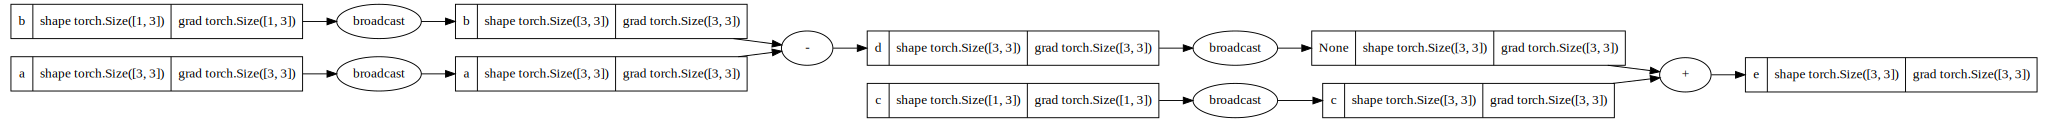

In [18]:
draw_dot(e_custom)

In [17]:
a = torch.tensor([[2,1,0],
                  [3,2,1],
                  [1,1,0]], dtype = torch.float32, requires_grad=True)
b = torch.tensor([[1,1,1],
                  [1,1,1],
                  [1,1,1]], dtype = torch.float32, requires_grad=True)
c = torch.randn((1,3), dtype = torch.float32, requires_grad=True)


a_custom = TensorValue(a, label = 'a')
b_custom = TensorValue(b, label = 'b')
c_custom = TensorValue(c, label = 'c')

d = c @ a

d_custom = c_custom @ a_custom
d_custom.label = 'd'

d_sum = d.sum()
d_sum.backward()
d_custom.backward()

print(a.grad)
print(b.grad)
print(c.grad)
print("Customs")
print(a_custom.grad)
print(c_custom.grad)

tensor([[ 1.0953,  1.0953,  1.0953],
        [-0.5881, -0.5881, -0.5881],
        [ 0.7633,  0.7633,  0.7633]])
None
tensor([[3., 6., 2.]])
Customs
tensor([[ 1.0953,  1.0953,  1.0953],
        [-0.5881, -0.5881, -0.5881],
        [ 0.7633,  0.7633,  0.7633]], grad_fn=<AddBackward0>)
tensor([[3., 6., 2.]], grad_fn=<AddBackward0>)


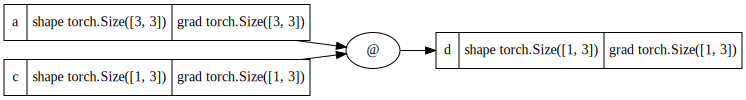

In [19]:
draw_dot(d_custom)